    SPEECH RECOGNITION

In [6]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
import pandas as pd
from torch.utils.data import Dataset
import os
import torchaudio

class My_Dataset(Dataset):

    def __init__(self, csv_file, root_dir, set_number):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the audio files.
            set_number (int): Set number to filter the samples.
        """
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.set_number = set_number
        self.filtered_indices = self.filter()

    def __len__(self):
        return len(self.filtered_indices)

    def filter(self):
        filtered_indices = []
        for idx in range(len(self.data)):
            set_value = int(self.data.iloc[idx, 1])
            if set_value == self.set_number:
                filtered_indices.append(idx)
        return filtered_indices

    def __getitem__(self, idx):
        idx = self.filtered_indices[idx]
        file = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        class_label = int(self.data.iloc[idx, 2])
        waveform, _ = torchaudio.load(file)
        return waveform, class_label

csv_file = 'dataset_2.csv'
root_dir = 'dataset'
train_dataset = My_Dataset(csv_file, root_dir, 0)
test_dataset = My_Dataset(csv_file, root_dir, 1)
valid_dataset = My_Dataset(csv_file, root_dir, 2)
print(train_dataset[0])
print(test_dataset[0])
print(valid_dataset[0])


(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0458,  0.0068,  0.0377]]), 1)
(tensor([[-0.0005, -0.0052,  0.0002,  ...,  0.0111,  0.0040,  0.0000]]), 4)
(tensor([[0.0018, 0.0032, 0.0043,  ..., 0.0025, 0.0015, 0.0013]]), 2)


In [3]:
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader
# from torchvision import datasets
from torchvision.transforms import ToTensor
plt.style.use('ggplot')

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

for batch, (X, y) in enumerate(train_loader):

    print(X.shape, y.shape)
    if batch == 3:
        break

#dimensiuni: cat mai patrat - 128x128
    

torch.Size([64, 1, 16000]) torch.Size([64])
torch.Size([64, 1, 16000]) torch.Size([64])
torch.Size([64, 1, 16000]) torch.Size([64])
torch.Size([64, 1, 16000]) torch.Size([64])


In [4]:
classes = ['down', 'left', 'right', 'stop', 'up']

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class M4(nn.Module):
    def __init__(self, n_input=1, n_output=5, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        # self.fc1 = nn.Linear(2 * n_channel, n_output)
        self.fc1 = nn.LazyLinear(n_output)
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = x.squeeze(1)
        return F.log_softmax(x, dim=1)


model = M4(n_input=1, n_output=len(classes))
model.to(device)
model(torch.randn([64, 1, 16000]))
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M4(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=5, bias=True)
)
Number

In [11]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1) 
criterion = nn.CrossEntropyLoss()

In [12]:

# Training function
def train(model, device, train_loader, optimizer, epoch, log_interval, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    train_losses = []
    train_accuracies = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # data =data.repeat(1, 3, 1, 1)
        # data = data.squeeze(1)  # Remove channel dimension
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    avg_loss = running_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    scheduler.step()
    return avg_loss, accuracy

In [13]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

all_preds = []
all_targets = []
# Testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0.0
    correct = 0
    test_losses = []
    test_accuracies = []
   
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # data = data.repeat(1, 3, 1, 1)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)  # Accumulate the loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader.dataset)  # Calculate average loss
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(avg_test_loss)
    test_accuracies.append(accuracy)
    print(f'\nTest set: Average loss: {avg_test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')
    return avg_test_loss, accuracy, all_preds, all_targets


In [14]:
n_epoch = 5
log_interval = 20
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

with tqdm(total=n_epoch) as pbar:
    train_epoch_losses = []
    train_epoch_accuracies = []
    test_epoch_losses = []
    test_epoch_accuracies = []
    all_preds = []
    all_targets = []
    for epoch in range(1, n_epoch + 1):
        loss, acc = train(model, device, train_loader, optimizer, epoch, log_interval, scheduler)
        train_epoch_losses.append(loss)
        train_epoch_accuracies.append(acc)

        loss, acc, preds, targets = test(model, device, test_loader)
        test_epoch_losses.append(loss)
        test_epoch_accuracies.append(acc)
        torch.save(model.state_dict(), 'best_gsc_command.pt')
        pbar.update(1)


  0%|          | 0/5 [00:00<?, ?it/s]

Train Epoch: 1 [0/13363 (0%)]	Loss: 1.640365
Train Epoch: 1 [1280/13363 (10%)]	Loss: 1.332633
Train Epoch: 1 [2560/13363 (19%)]	Loss: 1.186455
Train Epoch: 1 [3840/13363 (29%)]	Loss: 0.952115
Train Epoch: 1 [5120/13363 (38%)]	Loss: 0.853448
Train Epoch: 1 [6400/13363 (48%)]	Loss: 0.690528
Train Epoch: 1 [7680/13363 (57%)]	Loss: 0.710920
Train Epoch: 1 [8960/13363 (67%)]	Loss: 0.537639
Train Epoch: 1 [10240/13363 (77%)]	Loss: 0.496281
Train Epoch: 1 [11520/13363 (86%)]	Loss: 0.430941
Train Epoch: 1 [12800/13363 (96%)]	Loss: 0.478899


 20%|██        | 1/5 [00:16<01:06, 16.68s/it]


Test set: Average loss: 0.4552, Accuracy: 3307/3818 (87%)

Train Epoch: 2 [0/13363 (0%)]	Loss: 0.467527
Train Epoch: 2 [1280/13363 (10%)]	Loss: 0.392694
Train Epoch: 2 [2560/13363 (19%)]	Loss: 0.394011
Train Epoch: 2 [3840/13363 (29%)]	Loss: 0.209575
Train Epoch: 2 [5120/13363 (38%)]	Loss: 0.336870
Train Epoch: 2 [6400/13363 (48%)]	Loss: 0.398443
Train Epoch: 2 [7680/13363 (57%)]	Loss: 0.317127
Train Epoch: 2 [8960/13363 (67%)]	Loss: 0.305235
Train Epoch: 2 [10240/13363 (77%)]	Loss: 0.335171
Train Epoch: 2 [11520/13363 (86%)]	Loss: 0.310143
Train Epoch: 2 [12800/13363 (96%)]	Loss: 0.435538


 40%|████      | 2/5 [00:33<00:50, 16.98s/it]


Test set: Average loss: 0.2791, Accuracy: 3519/3818 (92%)

Train Epoch: 3 [0/13363 (0%)]	Loss: 0.252683
Train Epoch: 3 [1280/13363 (10%)]	Loss: 0.142392
Train Epoch: 3 [2560/13363 (19%)]	Loss: 0.231163
Train Epoch: 3 [3840/13363 (29%)]	Loss: 0.179339
Train Epoch: 3 [5120/13363 (38%)]	Loss: 0.261684
Train Epoch: 3 [6400/13363 (48%)]	Loss: 0.148048
Train Epoch: 3 [7680/13363 (57%)]	Loss: 0.191218
Train Epoch: 3 [8960/13363 (67%)]	Loss: 0.291033
Train Epoch: 3 [10240/13363 (77%)]	Loss: 0.141227
Train Epoch: 3 [11520/13363 (86%)]	Loss: 0.156602
Train Epoch: 3 [12800/13363 (96%)]	Loss: 0.166415


 60%|██████    | 3/5 [00:53<00:36, 18.12s/it]


Test set: Average loss: 0.2129, Accuracy: 3581/3818 (94%)

Train Epoch: 4 [0/13363 (0%)]	Loss: 0.234613
Train Epoch: 4 [1280/13363 (10%)]	Loss: 0.155592
Train Epoch: 4 [2560/13363 (19%)]	Loss: 0.099231
Train Epoch: 4 [3840/13363 (29%)]	Loss: 0.238979
Train Epoch: 4 [5120/13363 (38%)]	Loss: 0.198776
Train Epoch: 4 [6400/13363 (48%)]	Loss: 0.125842
Train Epoch: 4 [7680/13363 (57%)]	Loss: 0.191110
Train Epoch: 4 [8960/13363 (67%)]	Loss: 0.117572
Train Epoch: 4 [10240/13363 (77%)]	Loss: 0.298072
Train Epoch: 4 [11520/13363 (86%)]	Loss: 0.211835
Train Epoch: 4 [12800/13363 (96%)]	Loss: 0.115295


 80%|████████  | 4/5 [01:15<00:19, 19.54s/it]


Test set: Average loss: 0.1832, Accuracy: 3613/3818 (95%)

Train Epoch: 5 [0/13363 (0%)]	Loss: 0.128076
Train Epoch: 5 [1280/13363 (10%)]	Loss: 0.149494
Train Epoch: 5 [2560/13363 (19%)]	Loss: 0.118269
Train Epoch: 5 [3840/13363 (29%)]	Loss: 0.117214
Train Epoch: 5 [5120/13363 (38%)]	Loss: 0.215817
Train Epoch: 5 [6400/13363 (48%)]	Loss: 0.136981
Train Epoch: 5 [7680/13363 (57%)]	Loss: 0.133983
Train Epoch: 5 [8960/13363 (67%)]	Loss: 0.167522
Train Epoch: 5 [10240/13363 (77%)]	Loss: 0.123826
Train Epoch: 5 [11520/13363 (86%)]	Loss: 0.218323
Train Epoch: 5 [12800/13363 (96%)]	Loss: 0.144798


100%|██████████| 5/5 [01:32<00:00, 18.52s/it]


Test set: Average loss: 0.1772, Accuracy: 3607/3818 (94%)



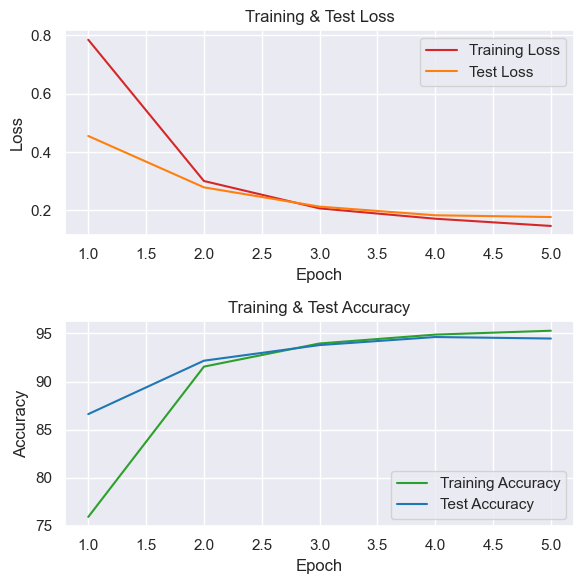

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Assuming the number of epochs is the length of the longest list
num_epochs = 100
epochs = range(1, num_epochs + 1)

# Create a figure with 2 subplots, vertically aligned, with a smaller size
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plot training loss and test loss in the same subplot
axs[0].plot(epochs[:len(train_epoch_losses)], train_epoch_losses, label='Training Loss', color='tab:red')
axs[0].plot(epochs[:len(test_epoch_losses)], test_epoch_losses, label='Test Loss', color='tab:orange')
axs[0].set_title('Training & Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training accuracy and test accuracy in the same subplot
axs[1].plot(epochs[:len(train_epoch_accuracies)], train_epoch_accuracies, label='Training Accuracy', color='tab:green')
axs[1].plot(epochs[:len(test_epoch_accuracies)], test_epoch_accuracies, label='Test Accuracy', color='tab:blue')
axs[1].set_title('Training & Test Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

              precision    recall  f1-score   support

        stop       0.91      0.94      0.93      3885
          up       0.92      0.89      0.90      3580
        down       0.92      0.91      0.91      3910
        left       0.96      0.92      0.94      3955
       right       0.91      0.95      0.93      3760

    accuracy                           0.92     19090
   macro avg       0.92      0.92      0.92     19090
weighted avg       0.92      0.92      0.92     19090

[[3659   49   82   58   37]
 [  95 3189  178   38   80]
 [  89  152 3570   18   81]
 [ 125   33   29 3625  143]
 [  56   45   37   38 3584]]


(<sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay at 0x1ab60d42990>,
 None)

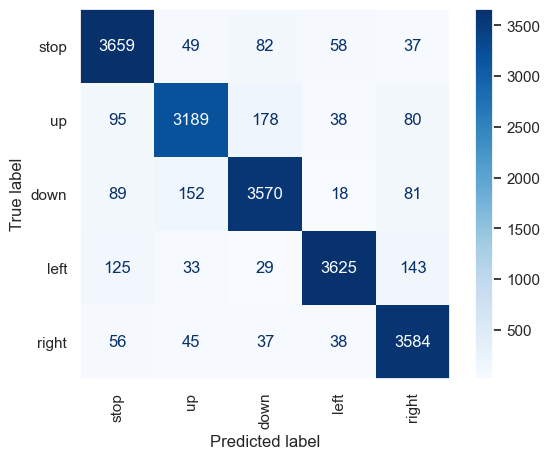

In [16]:
from sklearn.metrics import classification_report

report = classification_report(all_targets, all_preds, target_names=['stop', 'up', 'down', 'left', 'right'])  # Adjust target_names based on your dataset
print(report)
from sklearn.metrics import confusion_matrix

confision_matrix = confusion_matrix(all_targets, all_preds)
#print confusion matrix and labels
print(confision_matrix)


# confusion matrix display using sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the confusion matrix is stored in the variable confusion_matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confision_matrix, display_labels=['stop', 'up', 'down', 'left', 'right'])

#rempove the grid lines from the confusion matrix 
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical', ax=None), plt.grid(False)


In [33]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    return tensor

nr = 0
for i in range(len(valid_dataset)):
    waveform, utterance = valid_dataset[i]
    if utterance != predict(waveform).item():
        nr += 1
        print(f"Expected: {utterance}. Predicted: {predict(waveform).item()}.")

print(nr)

Expected: 2. Predicted: 3.
Expected: 3. Predicted: 4.
Expected: 2. Predicted: 0.
Expected: 3. Predicted: 4.
Expected: 1. Predicted: 0.
Expected: 2. Predicted: 1.
Expected: 2. Predicted: 1.
Expected: 1. Predicted: 2.
Expected: 4. Predicted: 3.
Expected: 3. Predicted: 2.
Expected: 3. Predicted: 0.
Expected: 3. Predicted: 4.
Expected: 1. Predicted: 0.
Expected: 0. Predicted: 3.
Expected: 0. Predicted: 3.
Expected: 3. Predicted: 1.
Expected: 3. Predicted: 0.
Expected: 1. Predicted: 2.
Expected: 3. Predicted: 0.
Expected: 4. Predicted: 0.
Expected: 2. Predicted: 1.
Expected: 1. Predicted: 4.
Expected: 4. Predicted: 3.
Expected: 3. Predicted: 1.
Expected: 3. Predicted: 4.
Expected: 3. Predicted: 4.
Expected: 1. Predicted: 2.
Expected: 2. Predicted: 1.
Expected: 1. Predicted: 2.
Expected: 3. Predicted: 4.
Expected: 2. Predicted: 1.
Expected: 0. Predicted: 3.
Expected: 2. Predicted: 0.
Expected: 0. Predicted: 3.
Expected: 2. Predicted: 1.
Expected: 0. Predicted: 3.
Expected: 4. Predicted: 1.
E